In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import numpy as np


import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset

#Get rid of SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  


In [2]:
PNW = pd.read_csv('../../Data/processedData/PNW/PNW.csv')
PNW = PNW.dropna()
PNW["flowering"] = PNW['reproductiveCondition'].isin(['flowering','flowering|fruiting','flowering|fruiting|flower budding','flowering|flower budding']).astype(int)
PNW["fruiting"] = PNW['reproductiveCondition'].isin(['fruiting','flowering|fruiting','flowering|fruiting|flower budding','fruiting|flower budding']).astype(int)

photoPath = "../../../PNW_Angiosperms/labeled_photos"

In [3]:
#I only have 49,999 so I'm missing one photo. The following code drops that row from the dataframe
for fname in PNW['file_name']: 
    if not os.path.isfile(photoPath + "/" + fname):
        PNW = PNW[PNW['file_name'] != fname]

In [4]:
photos = PNW[["file_name", "flowering"]].reset_index(drop=True)
photos_train, photos_val = train_test_split(list(photos.index), test_size=.25)
p_train= photos.iloc[photos_train]
p_val = photos.iloc[photos_val]

In [5]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#Some of our images are .pngs, we drop the alpha. 
train_transform = v2.Compose([
    #Rely on the v2 transforms from torchvision.transforms.v2

    #Use tensors instead of PIL images

    #Use torch.uint8 dtype, especially for resizing
                                v2.ToPILImage(),
                                v2.ToTensor(),
                                v2.RandomAffine(degrees=(-180,180), translate=(0,.1), scale=(.9,1)),
                                v2.RandomHorizontalFlip(p=0.5),
                                v2.RandomVerticalFlip(p=0.5),
                                v2.ColorJitter(brightness=.3, hue=.01)
                               #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

                            ])
val_transform = v2.Compose([
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                v2.ToPILImage(),
                                v2.ToTensor()
                            ])
target_transform = v2.Compose([
                                v2.Lambda(lambda x: torch.tensor(x).long()),
                            ])                         

c:\Users\Sean Haight\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, label_frame, img_dir, transform=None, target_transform=None):
        self.img_labels = label_frame
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
train_data = CustomImageDataset(p_train, photoPath, train_transform, target_transform)
val_data = CustomImageDataset(p_val, photoPath, val_transform, target_transform)

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 75, 75])
Labels batch shape: torch.Size([64])


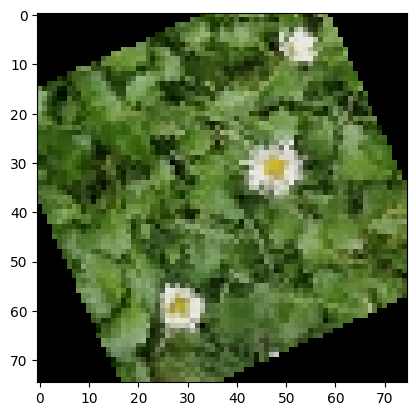

Label: 1


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [11]:
type(train_labels[0].item())

int

In [12]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(14400, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [13]:
model = ConvNeuralNet(2).to(device)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
num_epochs = 120

In [22]:
def train(num_epochs, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        
        #Turn the model into training mode
        model.train()

        for data, target in train_dataloader:
            optimizer.zero_grad()
            data = data.to(device)
            output = model(data)
            target=target.to(device)   
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            train_correct += (pred == target).sum().item()

        train_loss /= len(train_dataloader.dataset)
        train_acc = 100.0 * train_correct / len(train_dataloader.dataset)

        test_loss = 0.0
        test_correct = 0
        model.eval()

        with torch.no_grad():
            for data, target in val_dataloader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)

                test_loss += loss.item() * data.size(0)
                _, pred = torch.max(output, 1)
                test_correct += (pred == target).sum().item()

        test_loss /= len(val_dataloader.dataset)
        test_acc = 100.0 * test_correct / len(val_dataloader.dataset)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

In [19]:
torch.save(model.state_dict(), "../../Models/PNW/pytorch_CNN_1.pt")

In [24]:
train(5, .01)

Epoch 1: Train Loss: 0.5361, Train Acc: 71.10%, Test Loss: 0.5161, Test Acc: 72.82%
Epoch 2: Train Loss: 0.5210, Train Acc: 72.20%, Test Loss: 0.5063, Test Acc: 72.92%
Epoch 3: Train Loss: 0.5191, Train Acc: 72.25%, Test Loss: 0.5022, Test Acc: 73.32%
Epoch 4: Train Loss: 0.5137, Train Acc: 72.35%, Test Loss: 0.5321, Test Acc: 71.34%
Epoch 5: Train Loss: 0.5139, Train Acc: 72.25%, Test Loss: 0.5067, Test Acc: 72.77%


In [25]:
train(25, .01)

Epoch 1: Train Loss: 0.5105, Train Acc: 72.87%, Test Loss: 0.5109, Test Acc: 73.01%
Epoch 2: Train Loss: 0.5083, Train Acc: 72.90%, Test Loss: 0.5098, Test Acc: 73.06%
Epoch 3: Train Loss: 0.5078, Train Acc: 73.01%, Test Loss: 0.5142, Test Acc: 73.08%
Epoch 4: Train Loss: 0.5062, Train Acc: 72.95%, Test Loss: 0.5033, Test Acc: 73.33%
Epoch 5: Train Loss: 0.5049, Train Acc: 73.38%, Test Loss: 0.5016, Test Acc: 73.32%
Epoch 6: Train Loss: 0.5018, Train Acc: 73.40%, Test Loss: 0.4989, Test Acc: 73.79%
Epoch 7: Train Loss: 0.5036, Train Acc: 73.09%, Test Loss: 0.5066, Test Acc: 73.46%
Epoch 8: Train Loss: 0.5035, Train Acc: 73.36%, Test Loss: 0.5001, Test Acc: 73.72%
Epoch 9: Train Loss: 0.5031, Train Acc: 73.08%, Test Loss: 0.4966, Test Acc: 73.84%
Epoch 10: Train Loss: 0.4990, Train Acc: 73.24%, Test Loss: 0.5005, Test Acc: 73.89%
Epoch 11: Train Loss: 0.4995, Train Acc: 73.66%, Test Loss: 0.4999, Test Acc: 73.78%
Epoch 12: Train Loss: 0.4971, Train Acc: 73.58%, Test Loss: 0.5003, Test A

In [16]:
#Add random transformations to training data
#Test different hyperparameters
#Investigate ways to speed up training (SGD?)